In [18]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

import itertools

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal


#custom functions
from helpers import *

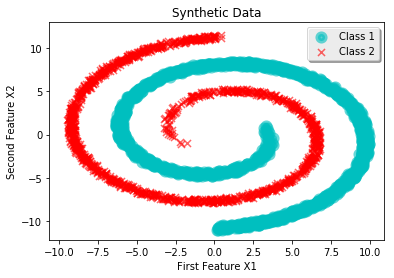

In [2]:
cA = np.loadtxt("./36_synthetic/class1.txt")
cB = np.loadtxt("./36_synthetic/class2.txt")

# Split data into training and testing
cA_train,cA_test,cB_train,cB_test = train_test_split(cA, cB, test_size=0.3, random_state=42) 

plt.scatter(cA_train[: , 0], cA_train[:, 1], s=50, c = 'c', marker = 'o', linewidths = 5, zorder = 10, alpha = 0.6, label='Class 1')
plt.scatter(cB_train[: , 0], cB_train[:, 1], s=50, c = 'r', marker = 'x', linewidths = 5, zorder = 10, alpha = 0.6, label='Class 2')

legend = plt.legend(loc='upper right', shadow=True)
plt.title("Synthetic Data")
plt.xlabel("First Feature X1")
plt.ylabel("Second Feature X2")
plt.show()

In [4]:
# generalised functions
def multivariate_gaussian(pos, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    return np.exp(-fac / 2) / N
    
def cal_pi_k(X, clusters):
    '''Calculate pi_k from initial KMeans step '''
    pi_k = []
    for i in clusters:
        pi_k.append(clusters[i].shape[0])
    return np.array(pi_k)/X.shape[0]

def recal_pi_k(gamma):
    '''Calculate pi_k(new) after an iteration from Expectation step'''
    K = gamma.shape[1]
    n_size = gamma.shape[0]
    mix = [0]*K
    for i in range(K):
        mix[i] = sum(gamma[:,i])/n_size
        
    return np.array(mix)

def cal_mu(X, gamma):
    '''Calculate Mu(new) after an iteration from Expectation step or initial KMeans step '''
    
    
    K = gamma.shape[1]
    
    new_centroids = np.empty((K,2))
    
    for k in range(K):
        # Denominator
        temp_sum= sum(gamma[:,k])
        
        temp_s = np.array([0,0], dtype='float64')
        
        # Numerator
        for n in range(X.shape[0]):
            temp_s += gamma[n][k]*X[n]
        if temp_sum > 1:
            new_centroids[k] = temp_s/temp_sum
    
    return new_centroids

def cal_sigma(X, gamma, mu):
    
    K = gamma.shape[1]
    new_sigma = np.empty((K , 2,2))
    
    for k in range(K):
        # Denominator
        temp_sum= sum(gamma[:,k])

        temp_s = np.array([[0,0], [0,0]], dtype='float64')
        # Numerator
        for n in range(X.shape[0]):
            t = (X[n] - mu[k]).reshape(1,2)
            temp_s += gamma[n][k] * np.matmul(np.transpose(t), t)

        new_sigma[k] = temp_s / temp_sum
        
    return new_sigma

def build_gamma(X, mix, mu, sigma):
    
    K = mix.shape[0]
    
    tmp = np.zeros([X.shape[0], K])
    
    for i in range(K):
        mean = mu[i]
        cov = sigma[i]        
        tmp[:, i] = mix[i]*multivariate_normal.pdf(X, mean, cov) # using inbuilt pdf
        #tmp[:, i] = mix[i]*multivariate_gaussian(U, mean, cov)  # self made pdf function
        
    gamma = np.zeros([X.shape[0], K])

    # Instead of using two data structures temp and gamma we can use only 1
    
    for i in range(X.shape[0]):
        temp_sum = sum(tmp[i, :])
        for j in range(K):
            gamma[i][j] = tmp[i][j] / temp_sum
            
    return gamma

def threshold(value, limit = 10**-3):
    return (abs(value)<=limit)

def em_repeat(gmm_initial, X):
    old_pi = gmm_initial.getpi()
    old_mu = gmm_initial.getmu()
    old_sigma = gmm_initial.getsigma()
    
    gamma = build_gamma(X, old_pi, old_mu, old_sigma)
    
    new_pi = recal_pi_k(gamma)
    new_mu = cal_mu(X, gamma)
    new_sigma = cal_sigma(X, gamma, new_mu)
    
    new_gmm = gmm(new_mu, new_sigma, new_pi)
    
    return new_gmm

def em_repeat_times(gmm, X, times=2):
    for _ in range(times):
        gmm = em_repeat(gmm, X)
        
    return gmm

def normalize(X):
    return (X-min(X))/(max(X)-min(X))

def classify(gA, gB, X):
    return 1 if (gA.predict_scores(X)>gB.predict_scores(X)).all() else 2

In [56]:
# GMM class

class gmm:
    def __init__(self, list_mu, list_sigma, list_pi):
        self.list_mu = list_mu
        self.list_sigma = list_sigma
        self.list_pi = list_pi
        
    def predict_scores(self, X):
        feature_size = self.list_mu.shape[1]
        X = X.reshape(-1,feature_size)
        scores = np.empty((X.shape[0], 1), dtype = "float64")
        
        for n in range(X.shape[0]):
            temp_s = 0
            for k in range(self.list_mu.shape[0]):
                rv = multivariate_normal(self.list_mu[k], self.list_sigma[k])
                #print(X[n], X[n].shape)
                temp_s += self.list_pi[k] * rv.pdf(X[n])
            scores[n] = temp_s
        return scores
    
    def getpi(self):
        return self.list_pi
    
    def getmu(self):
        return self.list_mu
    
    def getsigma(self):
        return self.list_sigma
        

In [46]:
def plot_KMeans(X, K=10):
    
    distortions = []
    for k in range(1,K):
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    # Plot the elbow
    plt.plot(range(1,K), distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
    cluster_size = K
    clf = KMeans(n_clusters = cluster_size)
    clf.fit(X)

    # Gives the final cetnroids of each cluster
    centroids = clf.cluster_centers_

    # Label of each data-point
    labels = clf.labels_


    colors = 10*["g", "r", "c", "b", "y","gray", "brown", "tan", "gold", "peru", "tomato", "aqua"]
    for i in range(len(X)):
        plt.scatter(X[i][0], X[i][1], c = colors[labels[i]], marker = 'o')

    plt.scatter(centroids[:, 0], centroids[:, 1], c= 'k', marker = 'x', s = 50,  zorder = 10)
    plt.show()
    
    clusters = {}
    #initialize
    for i in range(cluster_size):
        clusters[i] = []

    for i,j in zip(X, labels):
        clusters[j].append(i)

    for i in clusters:
        clusters[i] = np.array(clusters[i])
        
    # Our 2-dimensional distribution will be over variables X[0] and X[1]
    N = 60
    xs = np.linspace(min(X[:,0]), max(X[:,0]), N)
    ys = np.linspace(min(X[:,1]), max(X[:,1]), N)
    xs, ys = np.meshgrid(xs, ys)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(xs.shape + (2,))
    pos[:, :, 0] = xs
    pos[:, :, 1] = ys

    # Mean vector and covariance matrix
    for index in range(cluster_size):
        mu = centroids[index]
        Sigma = np.cov(np.transpose(clusters[index]))

        # The distribution on the variables X, Y packed into pos.
        Z = multivariate_gaussian(pos, mu, Sigma)

        plt.contour(xs, ys, Z)
        
    plt.scatter(centroids[:, 0], centroids[:, 1], c= 'k', marker = 'x', s = 50,  zorder = 10)    
    plt.show()

def pipeline(X, K=10):
    clf = KMeans(n_clusters = K)
    clf.fit(X)

    # Gives the final cetnroids of each cluster
    centroids = clf.cluster_centers_
    labels = clf.labels_
    
    clusters = {}
    #initialize
    for i in range(K):
        clusters[i] = []

    for i,j in zip(X, labels):
        clusters[j].append(i)

    for i in clusters:
        clusters[i] = np.array(clusters[i])
    
    
    #Start of EM Step
    initial_sigma = []
    for index in range(K):
        initial_sigma.append(np.cov(np.transpose(clusters[index])))

   # Initialization
    initial_sigma = np.array(initial_sigma).reshape(-1, 2,2)
    initial_mu = centroids
    initial_pi = cal_pi_k(X, clusters)
    

    g1 = gmm(initial_mu, initial_sigma, initial_pi)
    s1 = g1.predict_scores(X)
    
    g2 = em_repeat_times(g1, X, times = 1)
    s2 = g2.predict_scores(X)

    count_itr = 0
    while abs(sum(np.log(s2)) - sum(np.log(s1)))> 0.1 :
        s1 = g1.predict_scores(X)
        g2 = em_repeat_times(g1, X, times = 1)
        s2 = g2.predict_scores(X)
        g1 = g2
        count_itr+=1
        
    print("Iterations : {}".format(count_itr))
    return g2


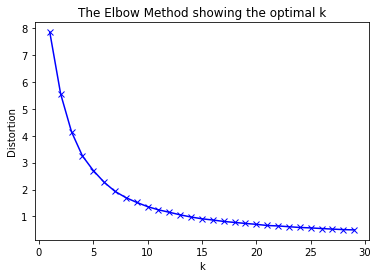

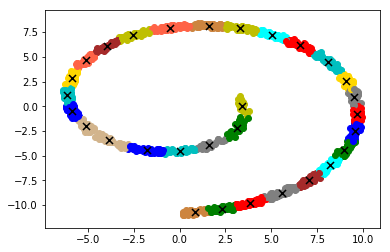

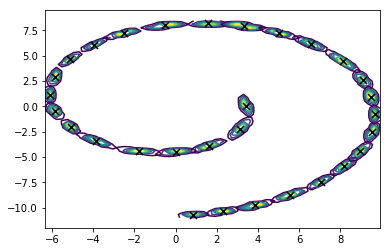

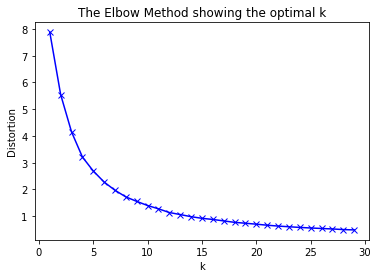

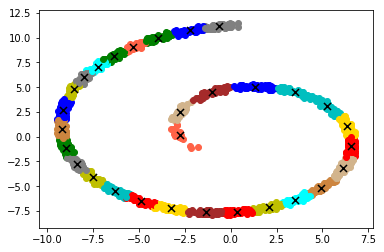

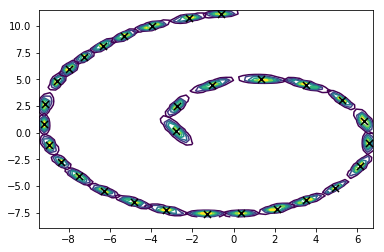

In [123]:
plot_KMeans(cA_train,30)
plot_KMeans(cB_train,30)

In [57]:
gA_new = pipeline(cA_train, K=7)
gB_new = pipeline(cB_train, K=10)

Iterations : 8
Iterations : 22


In [58]:
c_a=0
c_b=0
for i in range(cB_train.shape[0]):
    if 2 == classify(gA_new, gB_new, cB_train[i]):
        c_b+=1
    else:
        c_a+=1
print(c_a, c_b)

1 1399


In [59]:
c_a=0
c_b=0
for i in range(cB_train.shape[0]):
    if 2 == classify(gA_new, gB_new, cA_train[i]):
        c_b+=1
    else:
        c_a+=1
print(c_a, c_b)

1400 0


In [60]:
print(gA_new.predict_scores(cA_train[0]), gB_new.predict_scores(cA_train[0]))

[[ 0.01542468]] [[  5.97518662e-06]]


In [61]:
# Create Test Data and actualLabels

test_data = np.vstack((cA_test, cB_test))
actual = np.vstack((np.array([1]*cA_test.shape[0]), np.array([2]*cB_test.shape[0]))).reshape(-1,1)

counter = 0
for each in actual:
    if each == 1:
        counter+=1

In [63]:
counter

600

In [62]:
predictedValues = np.empty(actual.shape)
for i in range(test_data.shape[0]):
    predictedValues[i] = classify(gA_new, gB_new, test_data[i])
    
counter = 0 
for each in predictedValues:
    if each == 2:
        counter+=1

In [64]:
# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[600   0]
 [  0 600]]
Normalized confusion matrix
[[ 1.  0.]
 [ 0.  1.]]


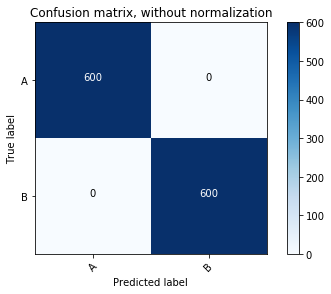

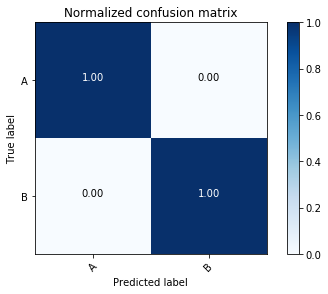

In [65]:
# Compute confusion matrix
actualValues = actual
cnf_matrix = confusion_matrix(actualValues, predictedValues)
np.set_printoptions(precision=2)
class_names = ['A', 'B'];

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [101]:
(0.65+0.33)/(0.65+0.33+0.67+0.35)

0.49

In [12]:
# Actual Scores

a_pred_A = gA_new.predict_scores(cA_test)
b_pred_B = gB_new.predict_scores(cB_test)

actual_scores = np.vstack((a_pred_A, b_pred_B))

In [13]:
# Predicted Scores for both the models

gA_scores = gA_new.predict_scores(test_data)
gB_scores = gB_new.predict_scores(test_data)

predicted_scores = np.vstack((gA_scores, gB_scores))

In [ ]:
for i in 
if gA_scores[i] > gB_scores[i]

In [14]:
actual_info = np.vstack((np.array([1]*cA_test.shape[0]), np.array([2]*cB_test.shape[0]), np.array([2]*cA_test.shape[0]), np.array([1]*cB_test.shape[0]))).reshape(-1,1)


In [22]:
# # Normalize scores
target = np.vstack((predicted_scores[:600], predicted_scores[1800:]))
non_target = predicted_scores[600: 1800]

# target = normalize(target)
# non_target = normalize(non_target)

In [ ]:
# plt.hist(target,20, alpha=0.7, label='Target', color='blue')
# plt.hist(non_target,20, alpha=0.7, label='Non Target', color='red')
# plt.legend(loc = "upper right")
# plt.show()

In [ ]:
#predicted_scores = np.vstack((target[:600], non_target, target[600:]))

In [ ]:
max(predicted_scores)

In [15]:
# ROC Curve

no_of_test_points = predicted_scores.shape[0]
no_of_classes = 2

predicted_info = np.zeros(actual_info.shape)

temp_t = 0

TP = 0
FP = 0
FN = 0
TN = 0

TPR = []
FPR = []
FNR = []
FDR = []
TNR = []
t = []

#threshold = 2.9;
for threshold in np.arange(min(predicted_scores) ,max(predicted_scores), 0.01):
    t.append(threshold)
    TP = 0
    FP = 0
    FN = 0
    TN = 0

    for i in range(0, no_of_test_points):
        if predicted_scores[i] >= threshold:
            predicted_info[i] = 1
        else:
            predicted_info[i] = 2

    for i in range(0, no_of_test_points):
        if actual_info[i] == 1 and predicted_info[i] == 1:
            TP += 1
        elif actual_info[i] == 1 and predicted_info[i] == 2:
            FN += 1
        elif actual_info[i] == 2 and predicted_info[i] == 1:
            FP += 1
        elif actual_info[i] == 2 and predicted_info[i] == 2:
            TN += 1

    tpr = TP / (TP + FN)  
    fpr = FP / (FP + TN)
    fnr = FN / (FN + TP)
    fdr = FP / (TP + FP)
    tnr = TN / (TN + FP)
    TPR.append(tpr)
    FPR.append(fpr)
    FNR.append(fnr)
    FDR.append(fdr)
    TNR.append(tnr)

In [16]:
predicted_info

array([[ 2.],
       [ 2.],
       [ 2.],
       ..., 
       [ 2.],
       [ 2.],
       [ 1.]])

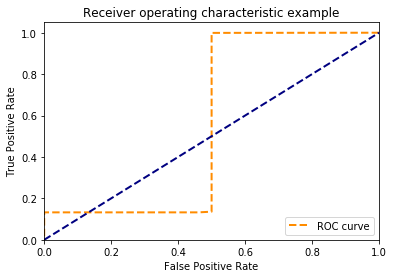

In [17]:
# Plot ROC

# plt.hist(TPR,20, alpha=0.7, label='TPR', color='blue')
# plt.hist(FPR,20, alpha=0.7, label='FPR', color='red')
# plt.legend(loc = "upper right")
# plt.show()



plt.figure()
lw = 2
plt.plot(FPR, TPR, color='darkorange', lw=lw, label='ROC curve', linestyle='--')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [25]:
target = np.vstack((predicted_scores[:600], predicted_scores[1800:]))
non_target = predicted_scores[600: 1800]

In [34]:
print(min(non_target))
print(max(non_target))

[  1.12738282e-09]
[ 10.36887234]


In [27]:
# ROC Curve

no_of_test_points = target.shape[0]
no_of_classes = 2

#predicted_info = np.zeros(actual_info.shape)

temp_t = 0

TP = 0
FP = 0
FN = 0
TN = 0

TPR = []
FPR = []
FNR = []
FDR = []
TNR = []
t = []

#threshold = 2.9;
for threshold in np.arange(min(non_target) ,max(target), 0.01):
    t.append(threshold)
    TP = 0
    FP = 0
    FN = 0
    TN = 0


    for i in range(0, no_of_test_points):
        if target[i] > threshold:
            TP += 1
        elif target[i] < threshold:
            FN += 1
            
        if non_target[i] > threshold:
            FP += 1
        elif non_target[i] < threshold:
            TN += 1

    tpr = TP / (TP + FN)  
    fpr = FP / (FP + TN)
    fnr = FN / (FN + TP)
    fdr = FP / (TP + FP)
    tnr = TN / (TN + FP)
    TPR.append(tpr)
    FPR.append(fpr)
    FNR.append(fnr)
    FDR.append(fdr)
    TNR.append(tnr)

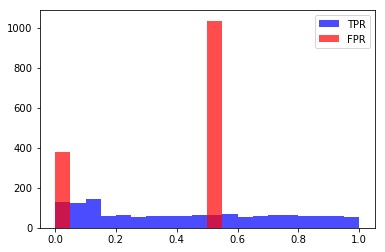

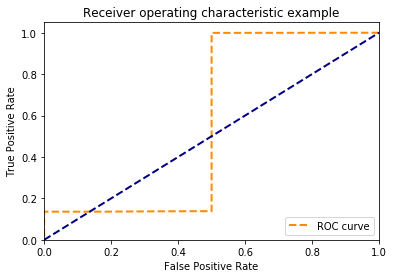

In [29]:
# Plot ROC

plt.hist(TPR,20, alpha=0.7, label='TPR', color='blue')
plt.hist(FPR,20, alpha=0.7, label='FPR', color='red')
plt.legend(loc = "upper right")
plt.show()



plt.figure()
lw = 2
plt.plot(FPR, TPR, color='darkorange', lw=lw, label='ROC curve', linestyle='--')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()